# Aprofundando em Gradient Boosting: XGBoost, LightGBM e CatBoost

Este notebook é um mergulho prático nas bibliotecas de Gradient Boosting mais poderosas e populares do mercado. Ele foi pensado como uma continuação natural do capítulo de **Modelos Ensemble**.

Enquanto o livro apresenta os conceitos fundamentais do Gradient Boosting (inclusive com a implementação `HistGradientBoostingClassifier` do Scikit-Learn), aqui nós vamos focar nas ferramentas que você encontrará em competições do Kaggle e em ambientes de produção de alta performance: **XGBoost, LightGBM e CatBoost**.

**O que vamos fazer?**
- **Comparar** as três bibliotecas em termos de API, velocidade e performance.
- **Visualizar** o comportamento dos modelos com curvas de aprendizado e gráficos de interpretabilidade (SHAP).
- **Explorar** funcionalidades avançadas como tratamento de features categóricas, constraints monotônicas e desbalanceamento de classes.

# Gradient Boosting na Prática: XGBoost, LightGBM e CatBoost

**Objetivo da aula/notebook**: apresentar, comparar e praticar as três bibliotecas modernas mais usadas para Gradient Boosted Decision Trees (GBDT) em dados tabulares: **XGBoost**, **LightGBM** e **CatBoost**. 

**Pré‑requisitos didáticos** (você já cobriu em aulas anteriores): Árvores de decisão, Random Forests, AdaBoost, Gradient Boosting (incluindo HGB do Scikit‑Learn), validação cruzada, overfitting/underfitting, métricas e *early stopping*.

**O que você vai ver aqui**:
1. Conceitos essenciais de GBDT e diferenças entre XGBoost/LightGBM/CatBoost
2. Setup + dataset tabular didático
3. *Baselines* simples (Regressão Logística / RandomForest) para comparação
4. Treinando **XGBoost**, **LightGBM** e **CatBoost** com *early stopping*
5. Tratamento de desbalanceamento, *categorical features* e *monotonic constraints*
6. Interpretação com SHAP
7. Boas práticas de *tuning* e *checklist* final


In [1]:
# Se necessário, descomente para instalar as bibliotecas:
#!pip install -U xgboost lightgbm catboost scikit-learn pandas matplotlib shap

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import KBinsDiscretizer

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

Este trecho prepara o ambiente para um fluxo clássico de classificação em Python. Importamos **NumPy** e **pandas** para manipular vetores e tabelas, e do scikit-learn trazemos o `train_test_split` para criar uma separação honesta entre treino e teste (idealmente estratificada) e as métricas **accuracy**, **F1** e **ROC-AUC**: a primeira é a taxa de acerto, a F1 equilibra precisão e recall e costuma ser preferida em cenários desbalanceados, enquanto a ROC-AUC avalia a separação global entre classes independente de limiar. O `classification_report` resume essas métricas por classe. Incluímos também o `KBinsDiscretizer`, que transforma variáveis contínuas em faixas (bins) — útil para induzir não linearidades simples ou ganhar interpretabilidade; em prática, ele deve ser ajustado só no conjunto de treino (via `Pipeline`) e aplicado em validação/teste para evitar vazamento de dados. Por fim, silenciamos avisos com `warnings.filterwarnings('ignore')` para deixar a saída mais limpa (use com parcimônia) e fixamos a semente com `np.random.seed(42)` para reprodutibilidade; ainda assim, convém definir `random_state` nos passos que tiverem aleatoriedade.


## 1) GBDT em 5 minutos: Uma Revisão Rápida

Lembrando do capítulo do Géron, o **Gradient Boosting** é uma técnica de ensemble onde novos modelos são adicionados sequencialmente para corrigir os erros dos seus predecessores. A ideia central é treinar cada novo modelo (geralmente uma árvore de decisão rasa) nos **resíduos** (ou gradientes da função de perda) do modelo anterior.

A fórmula geral é: $F_M(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$, onde cada $h_m$ é uma árvore treinada para corrigir os erros do conjunto $F_{m-1}(x)$.

Essa fórmula diz que o modelo final é a **soma de vários “ajustes” pequenos**. Cada (h_m(x)) é uma árvore simples treinada para **corrigir os erros** que o modelo atual ainda comete; pense em ir **colando remendos** onde ele falha. O peso $\gamma_m$ controla **quanto** dessa nova correção entra (passo/tamanho da contribuição). Começamos com uma previsão básica e, a cada passo, adicionamos mais uma árvore bem focada no que o modelo errou antes. No fim, a soma de muitas correções simples vira um modelo forte e flexível.


### Por que existem 3 bibliotecas tão populares?

Embora compartilhem a mesma base teórica, XGBoost, LightGBM e CatBoost implementam otimizações e funcionalidades distintas que as tornam mais ou menos adequadas para diferentes cenários.

| Característica | XGBoost (eXtreme Gradient Boosting) | LightGBM (Light Gradient Boosting Machine) | CatBoost (Categorical Boosting) |
| :--- | :--- | :--- | :--- |
| **Crescimento da Árvore** | Level-wise (nível a nível) | **Leaf-wise** (prioriza a folha com maior ganho) | Level-wise simétrico |
| **Velocidade** | Rápido, especialmente com `tree_method='hist'` | **Geralmente o mais rápido**, devido ao leaf-wise e GOSS¹ | Competitivo, mas pode ser mais lento |
| **Features Categóricas** | Requer pré-processamento (ex: One-Hot) | Suporte nativo (via tipo `category` do Pandas) | **Melhor da categoria**, com Ordered Target Statistics² |
| **Regularização** | L1/L2, `min_child_weight`, `max_depth` | `min_data_in_leaf`, `num_leaves` | `l2_leaf_reg`, `depth`, regularização de splits |
| **Pontos Fortes** | Robustez, ecossistema maduro, muito estável. | **Velocidade e eficiência** em datasets grandes. | **Qualidade out-of-the-box** com categóricas e bons defaults. |

- ¹ **GOSS** (*Gradient-based One-Side Sampling*): Foca nas instâncias com maiores gradientes (erros), acelerando o treino.
- ² **Ordered Target Statistics**: Uma forma inteligente de codificar categóricas que previne *target leakage*.

### Quando usar cada um? (Uma regra de bolso)

- **Muitas features categóricas (alta cardinalidade)?** Comece com **CatBoost**.
- **Dataset muito grande e a velocidade é crítica?** **LightGBM** é sua melhor aposta.
- **Precisa de máxima robustez e um ecossistema gigante?** **XGBoost** é a escolha segura e consagrada.

Nesta aula, vamos testar isso na prática!


## 2) Dataset didático (classificação)
Usaremos o `breast_cancer` do Scikit‑Learn (todas variáveis numéricas) e, para demonstrar o manuseio de **categóricas**, criaremos **variáveis discretizadas** (bins) e as trataremos como categóricas. Isso permite comparar o comportamento dos três pacotes.


In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Criar 3 variáveis categóricas artificiais via binning de numéricas
kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
cat_cols_src = ['mean radius', 'mean texture', 'mean perimeter']
X_bins = kb.fit_transform(X[cat_cols_src])
X_bins = pd.DataFrame(X_bins, columns=[c + '_bin' for c in cat_cols_src]).astype('int')

X_full = pd.concat([X, X_bins], axis=1)

# A estratificação em 'y' garante que treino e teste tenham proporções de classe similares
train_idx, test_idx = train_test_split(np.arange(len(X_full)), test_size=0.2, stratify=y, random_state=42)
X_train, X_test = X_full.iloc[train_idx].copy(), X_full.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

# Separar uma validação para early stopping a partir do conjunto de treino
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print("Dimensões dos datasets:")
print(f"  Treino (para fit final):     {X_tr.shape}")
print(f"  Validação (early stopping):  {X_val.shape}")
print(f"  Teste (avaliação final):     {X_test.shape}")


Dimensões dos datasets:
  Treino (para fit final):     (364, 33)
  Validação (early stopping):  (91, 33)
  Teste (avaliação final):     (114, 33)


In [3]:
print (data.feature_names)
print (data.target_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


**load_breast_cancer (sklearn) — Legenda das features**
* **mean radius** — média do raio (centro→contorno)
* **mean texture** — variação do tom (desv-padrão do cinza)
* **mean perimeter** — perímetro do contorno
* **mean area** — área do núcleo
* **mean smoothness** — “suavidade” (variação local do raio)
* **mean compactness** — compacidade (≈ P²/Área − 1)
* **mean concavity** — profundidade das concavidades
* **mean concave points** — nº de pontos/trechos côncavos
* **mean symmetry** — simetria do núcleo
* **mean fractal dimension** — complexidade/fractal do contorno
* **radius error** — erro padrão do raio
* **texture error** — erro padrão do tom
* **perimeter error** — erro padrão do perímetro
* **area error** — erro padrão da área
* **smoothness error** — erro padrão da suavidade
* **compactness error** — erro padrão da compacidade
* **concavity error** — erro padrão da concavidade
* **concave points error** — erro padrão dos pontos côncavos
* **symmetry error** — erro padrão da simetria
* **fractal dimension error** — erro padrão da dimensão fractal
* **worst radius** — maior raio (pior caso)
* **worst texture** — pior variação do tom
* **worst perimeter** — maior perímetro
* **worst area** — maior área
* **worst smoothness** — pior suavidade
* **worst compactness** — pior compacidade
* **worst concavity** — pior concavidade
* **worst concave points** — máximo de pontos côncavos
* **worst symmetry** — pior simetria
* **worst fractal dimension** — pior complexidade/fractal


In [4]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
print(X.describe())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

In [6]:
print("Primeiras linhas das features (X):")
print(X.head())

Primeiras linhas das features (X):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst textu

In [7]:
print("\nPrimeiras linhas do target (y):")
print(y.head())



Primeiras linhas do target (y):
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


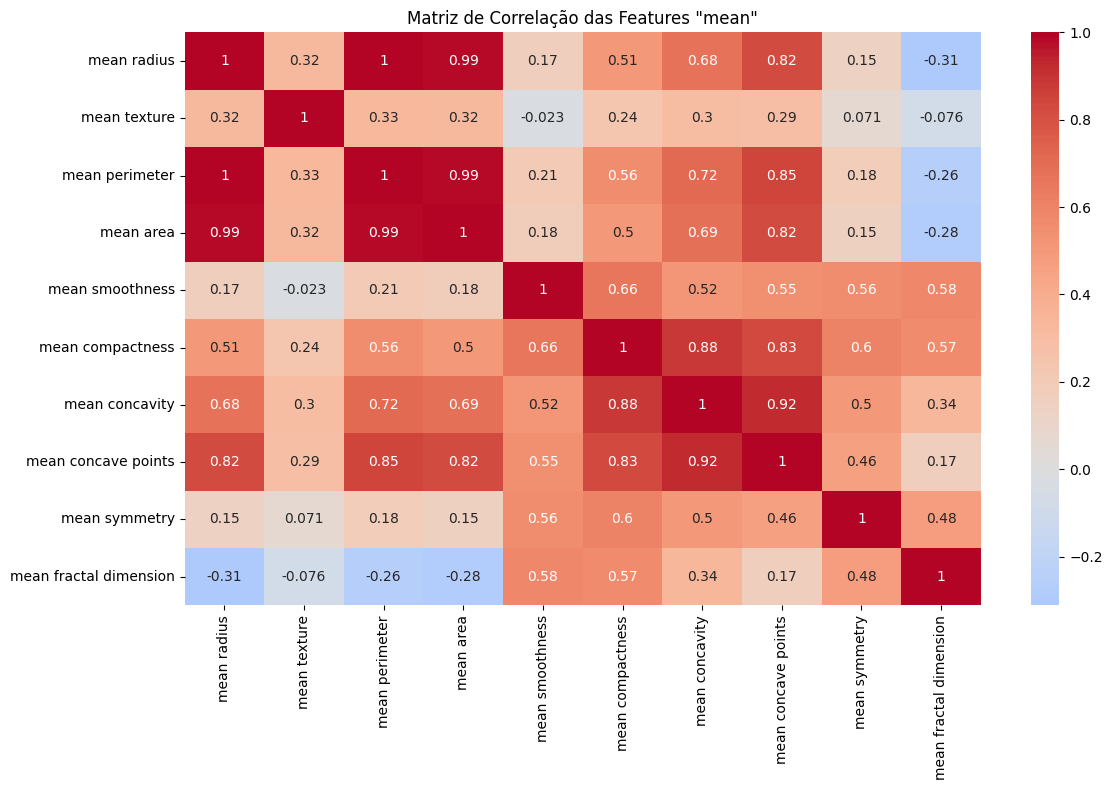

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecionando apenas as features com 'mean' no nome para a análise de correlação
featureMeans = [col for col in X.columns if 'mean' in col]

# Calculando a matriz de correlação
correlationData = X[featureMeans].corr()

# Criando um heatmap da matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlationData, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação das Features "mean"')
plt.tight_layout()
plt.show()


Gerando pairplot (pode demorar um pouco)...


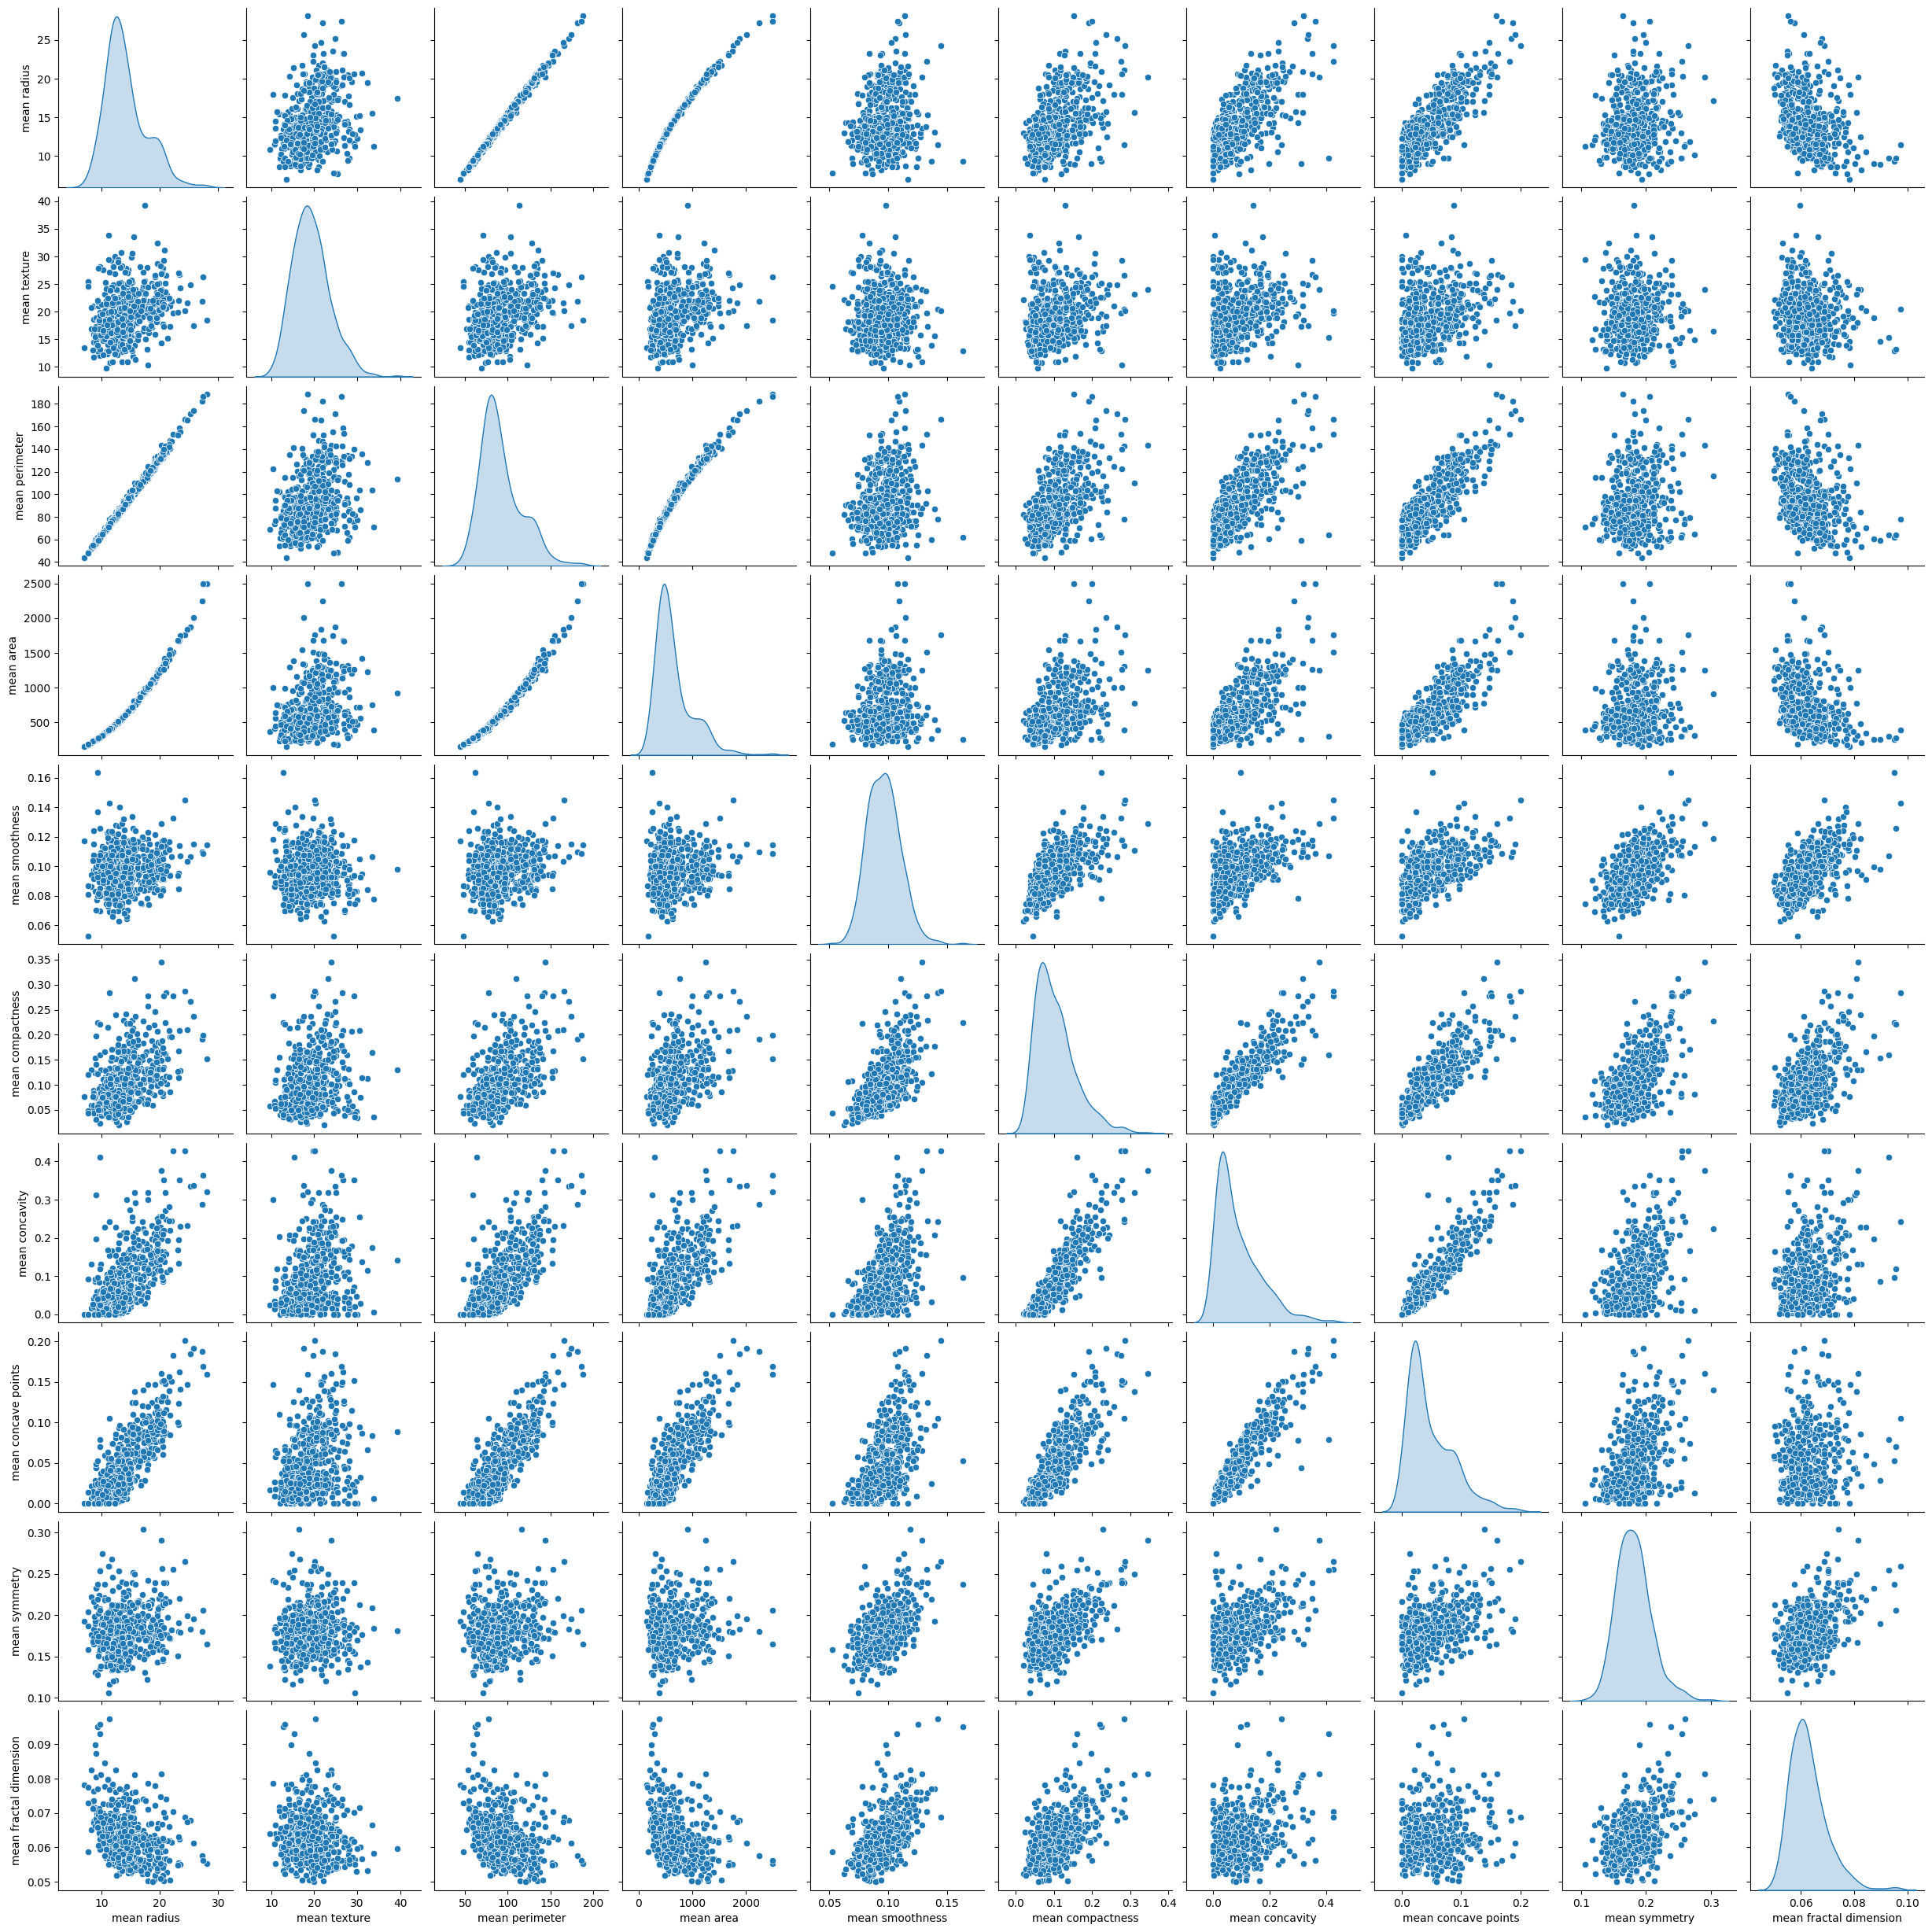

In [9]:
# Criando o pairplot
print("\nGerando pairplot (pode demorar um pouco)...")
sns.pairplot(X[featureMeans], diag_kind='kde')
plt.show()

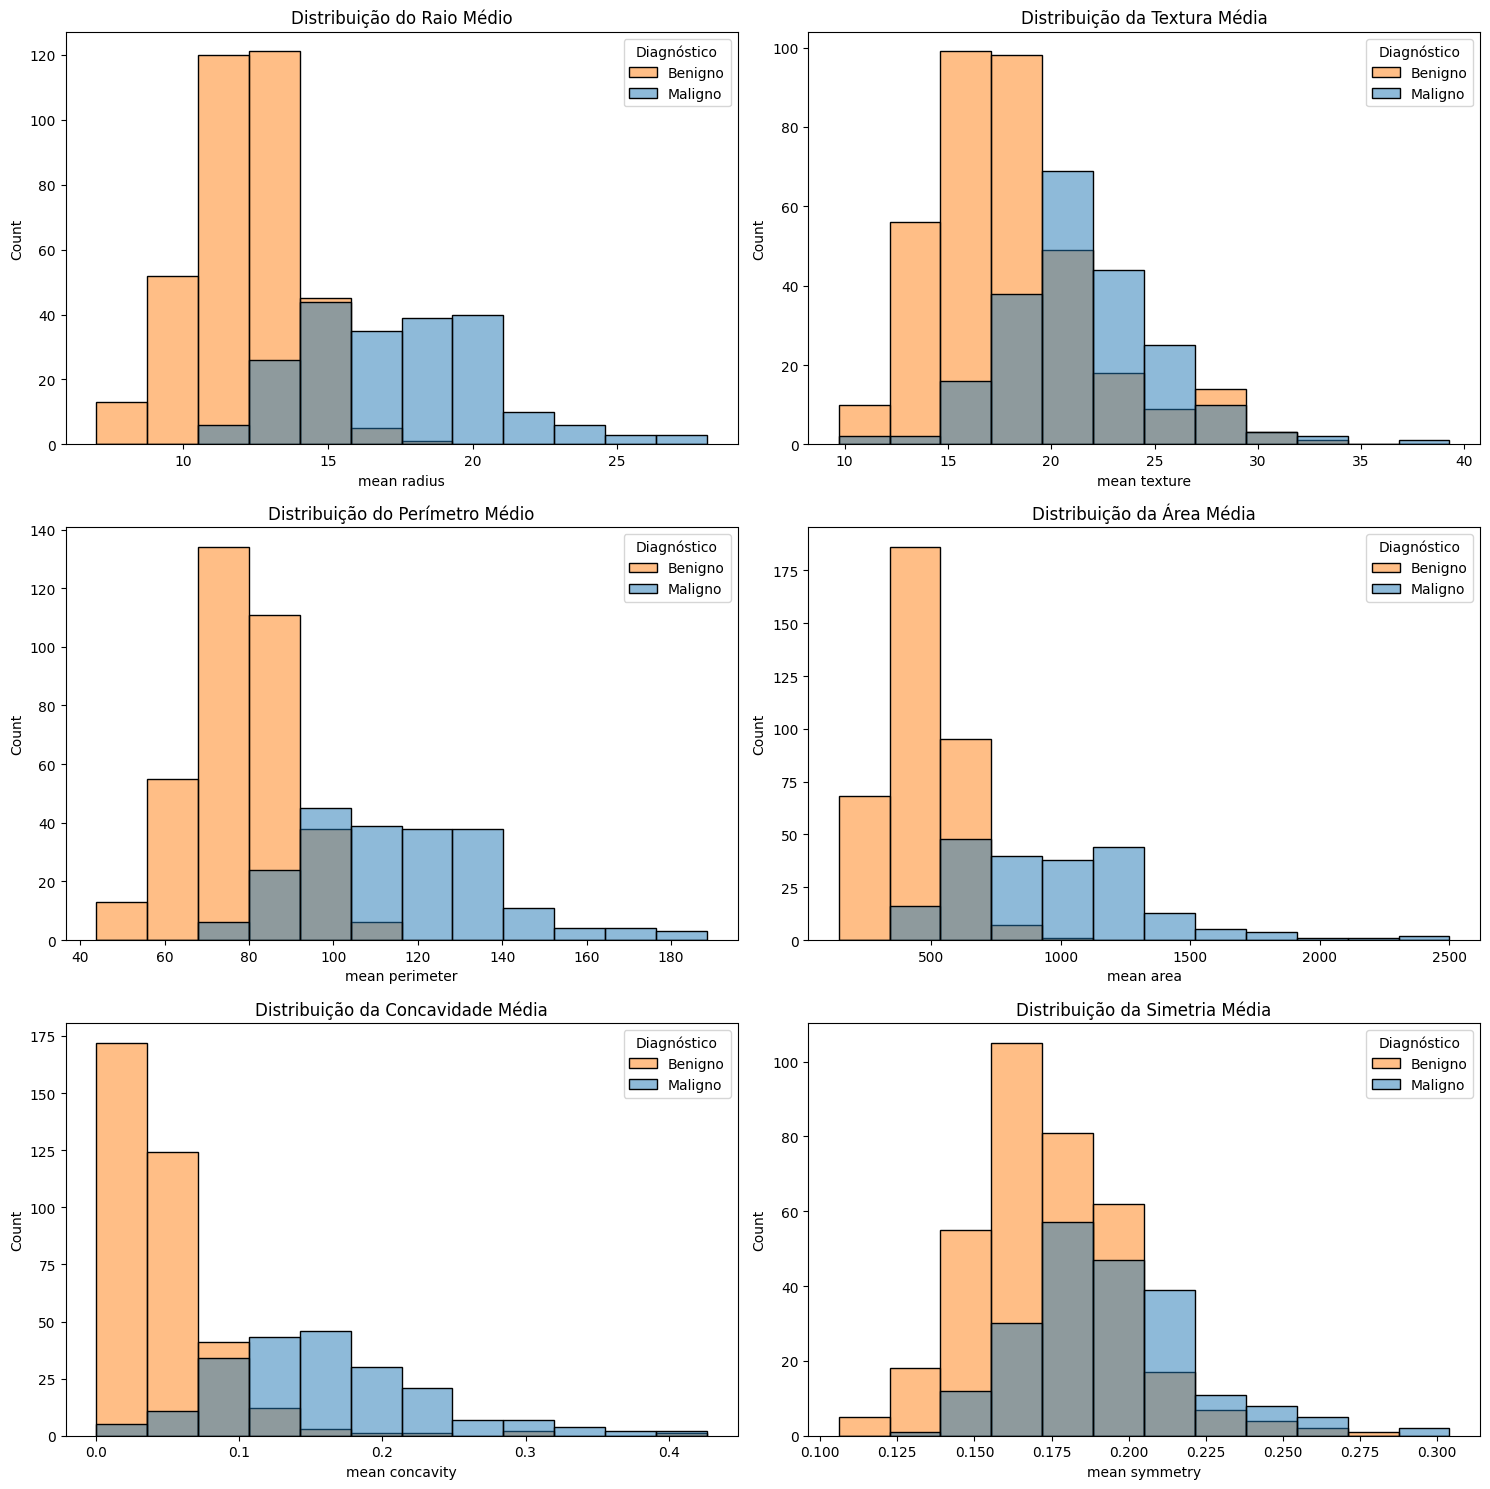

In [10]:
# Criando um DataFrame com os dados e o diagnóstico
df = X.copy()
df['diagnosis'] = y.map({0: 'M', 1: 'B'})  # 0 é maligno (M) e 1 é benigno (B)

# Configurando o estilo e tamanho da visualização
bins = 12
plt.figure(figsize=(15,15))

# Subplot 1: radius_mean
plt.subplot(3, 2, 1)
sns.histplot(data=df, x='mean radius', hue='diagnosis', bins=bins, multiple="layer", alpha=0.5)
plt.title('Distribuição do Raio Médio')
plt.legend(title='Diagnóstico', labels=['Benigno', 'Maligno'])

# Subplot 2: texture_mean
plt.subplot(3, 2, 2)
sns.histplot(data=df, x='mean texture', hue='diagnosis', bins=bins, multiple="layer", alpha=0.5)
plt.title('Distribuição da Textura Média')
plt.legend(title='Diagnóstico', labels=['Benigno', 'Maligno'])

# Subplot 3: perimeter_mean
plt.subplot(3, 2, 3)
sns.histplot(data=df, x='mean perimeter', hue='diagnosis', bins=bins, multiple="layer", alpha=0.5)
plt.title('Distribuição do Perímetro Médio')
plt.legend(title='Diagnóstico', labels=['Benigno', 'Maligno'])

# Subplot 4: area_mean
plt.subplot(3, 2, 4)
sns.histplot(data=df, x='mean area', hue='diagnosis', bins=bins, multiple="layer", alpha=0.5)
plt.title('Distribuição da Área Média')
plt.legend(title='Diagnóstico', labels=['Benigno', 'Maligno'])

# Subplot 5: concavity_mean
plt.subplot(3, 2, 5)
sns.histplot(data=df, x='mean concavity', hue='diagnosis', bins=bins, multiple="layer", alpha=0.5)
plt.title('Distribuição da Concavidade Média')
plt.legend(title='Diagnóstico', labels=['Benigno', 'Maligno'])

# Subplot 6: symmetry_mean
plt.subplot(3, 2, 6)
sns.histplot(data=df, x='mean symmetry', hue='diagnosis', bins=bins, multiple="layer", alpha=0.5)
plt.title('Distribuição da Simetria Média')
plt.legend(title='Diagnóstico', labels=['Benigno', 'Maligno'])

# Ajustando o layout e mostrando o gráfico
plt.tight_layout()
plt.show()


In [11]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Criar 3 variáveis categóricas artificiais via binning de numéricas
kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
cat_cols_src = ['mean radius', 'mean texture', 'mean perimeter']
X_bins = kb.fit_transform(X[cat_cols_src])
X_bins = pd.DataFrame(X_bins, columns=[c + '_bin' for c in cat_cols_src]).astype('int')

X_full = pd.concat([X, X_bins], axis=1)

train_idx, test_idx = train_test_split(np.arange(len(X_full)), test_size=0.2, stratify=y, random_state=42)
X_train, X_test = X_full.iloc[train_idx].copy(), X_full.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

# Separar uma validação para early stopping
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(X_tr.shape, X_val.shape, X_test.shape)

(364, 33) (91, 33) (114, 33)


## 3) Baselines rápidos
Sempre compare contra algo simples. Aqui usamos **Regressão Logística** e **RandomForest** como referência.

In [12]:
# =============================
# Baselines: Logistic + RandomForest
# =============================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def eval_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te, name="model"):
    """
    Treina o modelo, faz predição no conjunto de teste e retorna métricas (ACC, F1, AUC).
    - Usa predict_proba se existir, senão assume probabilidade 0.5 (baseline aleatório).
    """
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    
    # tenta pegar predict_proba, senão usa baseline neutro
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)
        if proba.shape[1] == 2:  # binário
            auc = roc_auc_score(y_te, proba[:, 1])
        else:
            auc = np.nan
    else:
        auc = np.nan
    
    return {
        "model": name,
        "acc": accuracy_score(y_te, pred),
        "f1": f1_score(y_te, pred),
        "auc": auc
    }


results_baseline = []  # <<< nova lista separada

lr = LogisticRegression(max_iter=500)
results_baseline.append(eval_model(lr, X_tr, y_tr, X_val, y_val, X_test, y_test, name='LogisticRegression'))

rf = RandomForestClassifier(n_estimators=300, random_state=42)
results_baseline.append(eval_model(rf, X_tr, y_tr, X_val, y_val, X_test, y_test, name='RandomForest'))

pd.DataFrame(results_baseline)


,model,acc,f1,auc
0,LogisticRegression,0.964912,0.972222,0.995370
1,RandomForest,0.947368,0.958333,0.992725


## 4) XGBoost
> **XGBoost**
Implementa *gradient boosting* com árvores de decisão de forma altamente otimizada. É robusto, tem regularização (L1/L2), lida bem com valores ausentes e oferece *early stopping*. Ótimo “padrão-ouro” para tabulares; use `tree_method='hist'` (ou `gpu_hist`) para velocidade.

**Destaques**:
- Penalização explícita de folhas (reg_lambda, reg_alpha)
- `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`
- *Early stopping* com `eval_set` e `early_stopping_rounds`
- Parâmetros úteis p/ desbalanceamento: `scale_pos_weight`

**Observação**: usamos a API *scikit‑learn* (`XGBClassifier`) para simplicidade.

In [13]:
import time
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- Parâmetros equivalentes ao seu XGBClassifier ---
params = {
    "objective": "binary:logistic",
    "eta": 0.03,                # learning_rate
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,              # reg_lambda
    "alpha": 0.0,               # reg_alpha
    "eval_metric": "auc",
    "tree_method": "hist",      # use 'gpu_hist' se tiver GPU
    "seed": 42
}

num_boost_round = 2000
early_stopping_rounds = 100

# --- Helper: cria DMatrix aceitando pandas 'category' (com fallback p/ códigos) ---
def make_dmatrix(X, y=None):
    cat_cols = list(getattr(X, "select_dtypes", lambda **k: [])(include=["category"]).columns) if hasattr(X, "select_dtypes") else []
    if len(cat_cols) == 0:
        return xgb.DMatrix(X, label=y)
    try:
        return xgb.DMatrix(X, label=y, enable_categorical=True)
    except Exception:
        Xc = X.copy()
        for c in cat_cols:
            Xc[c] = Xc[c].cat.codes.astype("int32")
        return xgb.DMatrix(Xc, label=y)

# DMatrix (robusto a colunas categóricas)
dtrain = make_dmatrix(X_tr, y_tr)
dval   = make_dmatrix(X_val, y_val)
dtest  = make_dmatrix(X_test)

evals = [(dtrain, "train"), (dval, "validation")]

# <- dicionário que será preenchido pelo train()
evals_res = {}

start_time = time.time()
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    evals_result=evals_res,          # 👈 coleta as curvas aqui
    verbose_eval=False
)
xgb_time = time.time() - start_time

# Curvas para plot
training_curves = {
    "XGBoost": {
        "train": evals_res["train"]["auc"],
        "val":   evals_res["validation"]["auc"],
        "best_iter": getattr(booster, "best_iteration", None)
    }
}

# Predição usando a melhor iteração (compatível com 1.x e 2.x)
best_iter = getattr(booster, "best_iteration", None)
best_ntree_limit = getattr(booster, "best_ntree_limit", 0)

if best_iter is not None:
    # API nova (2.x): iteration_range
    proba = booster.predict(dtest, iteration_range=(0, best_iter + 1))
elif best_ntree_limit > 0:
    # API antiga (1.x): ntree_limit
    proba = booster.predict(dtest, ntree_limit=best_ntree_limit)
else:
    # fallback: usa tudo que foi treinado
    proba = booster.predict(dtest)

pred = (proba >= 0.5).astype(np.int32)

print(f"Tempo de treino do XGBoost: {xgb_time:.2f} segundos")
print("XGB - ACC:", accuracy_score(y_test, pred))
print("XGB - F1 :", f1_score(y_test, pred))
print("XGB - AUC:", roc_auc_score(y_test, proba))
print("Melhor iteração (early stopping):", best_iter)

Tempo de treino do XGBoost: 0.31 segundos
XGB - ACC: 0.9385964912280702
XGB - F1 : 0.951048951048951
XGB - AUC: 0.9930555555555556
Melhor iteração (early stopping): 192


Este código treina um **XGBoost** via API nativa (`xgb.train`) usando matrizes otimizadas **`DMatrix`** para treino, validação e teste. Os hiperparâmetros definem um **modelo aditivo de árvores** para classificação binária (`objective='binary:logistic'`), com taxa de aprendizado `eta=0.03`, profundidade `max_depth=5` e amostragens de linhas/colunas (`subsample`, `colsample_bytree`) para reduzir overfitting; `lambda`/`alpha` controlam regularização L2/L1. O treinamento roda até `num_boost_round=2000`, mas usa **early stopping** com base na **AUC** em validação (`eval_metric='auc'`, `early_stopping_rounds=100`), salvando as curvas em `evals_res` e retornando `best_iteration`, isto é, o número ideal de árvores. Na predição, o código utiliza apenas as árvores até a melhor iteração (`iteration_range` ou `ntree_limit` conforme a versão), gerando probabilidades e convertendo-as em rótulos com limiar 0,5. Por fim, avalia o desempenho com **accuracy**, **F1** e **ROC-AUC**, permitindo comparar qualidade geral, equilíbrio entre precisão/recall e separação entre classes.


## 5) LightGBM

> **LightGBM**  
Também é *gradient boosting*, mas usa binning/histogramas e crescimento folha-a-folha, treinando muito rápido em dados grandes. Costuma alcançar alta acurácia com poucos recursos; aceita categorias como `category` no pandas, o que simplifica o *pipeline*.

**Destaques**:
- Treinamento **leaf‑wise** (best‑first) + *histogram binning* (muito rápido)
- Parâmetros chave: `num_leaves`, `max_depth`, `min_data_in_leaf`, `feature_fraction`, `bagging_fraction`
- *Early stopping* via `eval_set`/`callbacks`
- Lida com categóricas via *category dtype* (pandas)


In [14]:
import lightgbm as lgb
import time
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Criar cópias dos dados para não afetar outras partes do código
X_tr_lgb = X_tr.copy()
X_val_lgb = X_val.copy()
X_test_lgb = X_test.copy()

# Substituir espaços por underlines nos nomes das colunas
X_tr_lgb.columns = X_tr_lgb.columns.str.replace(' ', '_')
X_val_lgb.columns = X_val_lgb.columns.str.replace(' ', '_')
X_test_lgb.columns = X_test_lgb.columns.str.replace(' ', '_')

# Identificar as colunas categóricas (todas que terminam com '_bin')
lgb_cols_cat = [c for c in X_tr_lgb.columns if c.endswith('_bin')]

# Converter apenas se ainda não forem categóricas
for c in lgb_cols_cat:
    if not pd.api.types.is_categorical_dtype(X_tr_lgb[c]):
        X_tr_lgb[c] = X_tr_lgb[c].astype('category')
        X_val_lgb[c] = X_val_lgb[c].astype('category')
        X_test_lgb[c] = X_test_lgb[c].astype('category')

lgbm = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary',
    random_state=42
)

start_time = time.time()
lgbm.fit(
    X_tr_lgb, y_tr,
    eval_set=[(X_tr_lgb, y_tr), (X_val_lgb, y_val)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=150, verbose=False),
        lgb.log_evaluation(period=0)  # silencia logs mas guarda histórico
    ]
)
lgbm_time = time.time() - start_time

# Resultados de treino
results_lgbm = lgbm.evals_result_
training_curves['LightGBM'] = {
    'train': results_lgbm['training']['auc'],
    'val': results_lgbm['valid_1']['auc'],
    'best_iter': lgbm.best_iteration_
}

pred = lgbm.predict(X_test_lgb)
proba = lgbm.predict_proba(X_test_lgb)[:, 1]

print(f"Tempo de treino do LightGBM: {lgbm_time:.2f} segundos")
print("LGBM - ACC:", accuracy_score(y_test, pred))
print("LGBM - F1 :", f1_score(y_test, pred))
print("LGBM - AUC:", roc_auc_score(y_test, proba))
print(f"Melhor iteração (early stopping): {lgbm.best_iteration_}")


[LightGBM] [Info] Number of positive: 228, number of negative: 136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3666
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626374 -> initscore=0.516691
[LightGBM] [Info] Start training from score 0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Este código prepara e treina um **LightGBM** para classificação binária. Primeiro, converte as colunas `*_bin` para `category`, permitindo que o LightGBM trate categorias **nativamente** (sem one-hot) e ganhe velocidade. O modelo é configurado com **muitas árvores** (`n_estimators=5000`) e **passos pequenos** (`learning_rate=0.02`), controlando a complexidade via **`num_leaves`** (capacidade da árvore) e usando **subamostragem** de linhas/colunas (`subsample`, `colsample_bytree`) para reduzir overfitting. O treino monitora **AUC** em treino e validação e usa **early stopping** (paciência de 150 iterações) para parar no melhor ponto, salvando as curvas em `evals_result_` e a `best_iteration_` para análise posterior. Por fim, gera **probabilidades e previsões** no teste e reporta **Accuracy, F1 e ROC-AUC**, além do **tempo de treino**.


## 6) CatBoost

> **CatBoost**
*Gradient boosting* focado em lidar **nativamente** com variáveis categóricas (codificação ordenada) e em reduzir *overfitting*. Funciona bem “*out-of-the-box*”, exige pouca engenharia de *features* e costuma ser estável em bases com muitas categorias.

**Destaques**:
- Trata **categóricas** nativamente via *ordered target statistics*
- **Ordered Boosting** reduz vazamento de alvo (*target leakage*)
- Bons *defaults* e convergência estável, mesmo sem *tuning* pesado

Para usarmos categóricas, passaremos os **índices** das colunas categóricas (as `_bin`).

In [15]:
from catboost import CatBoostClassifier, Pool

# Definir colunas categóricas
cat_cols_idx = [i for i, c in enumerate(X_tr.columns) if c.endswith('_bin')]

# Criar Pools
train_pool = Pool(X_tr, y_tr, cat_features=cat_cols_idx)
val_pool   = Pool(X_val, y_val, cat_features=cat_cols_idx)
test_pool  = Pool(X_test, y_test, cat_features=cat_cols_idx)

# Treinar o modelo
cbc = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.02,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    od_type="Iter",
    od_wait=100,
    verbose=False
)

cbc.fit(train_pool, eval_set=val_pool)

# Agora sim funciona:
results_cbc = cbc.get_evals_result()

# Métricas finais
pred  = cbc.predict(test_pool)
proba = cbc.predict_proba(test_pool)[:, 1]

print("CatBoost - ACC:", accuracy_score(y_test, pred))
print("CatBoost - F1 :", f1_score(y_test, pred))
print("CatBoost - AUC:", roc_auc_score(y_test, proba))
print("Melhor iteração:", cbc.get_best_iteration())


CatBoost - ACC: 0.956140350877193
CatBoost - F1 : 0.9659863945578231
CatBoost - AUC: 0.9887566137566137
Melhor iteração: 8


Este trecho extrai do **CatBoost** as curvas de avaliação e registra o que for disponível: tenta usar **AUC** (caso o treino tenha sido configurado com `eval_metric='AUC'`) e, se não houver, cai para perdas como **logloss**. Com `get_evals_result()` pegamos os históricos de **learn** (treino) e **validation** (validação), identificamos dinamicamente o nome da métrica, guardamos em `training_curves['CatBoost']` as séries de treino/val e a **melhor iteração** determinada pelo **early stopping**. Em seguida, geramos **rótulos** (`predict`) e **probabilidades** (`predict_proba`) no conjunto de teste (`test_pool`) e reportamos **Accuracy**, **F1** e **ROC-AUC**, além do tempo e dos nomes das métricas efetivamente logadas, garantindo rastreabilidade mesmo quando o CatBoost muda o rótulo das métricas.


## Análise Comparativa dos Modelos

Vamos analisar o desempenho dos três modelos sob diferentes perspectivas:

1. **Curvas de Aprendizado**: Como o AUC evolui durante o treinamento (treino vs. validação)
2. **Curvas ROC**: Comparação direta da performance final
3. **Tempo de Treinamento**: Qual modelo é mais rápido
4. **Métricas Consolidadas**: Tabela com todas as métricas relevantes


In [16]:
# =============================
# Grid fino do XGBoost (Learning Rate)
# =============================
import time
import pandas as pd
import xgboost as xgb

# Certifique-se que best_complexity_params e rs_random.best_params_ existem
best_params = {}
try:
    best_params.update(best_complexity_params)
    best_params.update(rs_random.best_params_)
except NameError:
    print("⚠️ Aviso: Parâmetros de complexidade/aleatorização não encontrados. Usando defaults.")
    best_params = {
        "max_depth": 5,
        "min_child_weight": 1,
        "gamma": 0.0,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "colsample_bylevel": 0.9
    }

learning_rates = [0.01, 0.03, 0.05, 0.07, 0.1]
xgb_tuning_results = []

# 🔧 Converter colunas categóricas para inteiros (necessário no XGBoost 1.x)
X_tr_xgb = X_tr.copy()
X_val_xgb = X_val.copy()
for c in X_tr_xgb.select_dtypes(include="category").columns:
    X_tr_xgb[c] = X_tr_xgb[c].cat.codes
    X_val_xgb[c] = X_val_xgb[c].cat.codes

dtrain = xgb.DMatrix(X_tr_xgb, label=y_tr)
dval   = xgb.DMatrix(X_val_xgb, label=y_val)

for lr in learning_rates:
    params = {
        "objective": "binary:logistic",
        "eta": lr,
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "gamma": best_params["gamma"],
        "subsample": best_params["subsample"],
        "colsample_bytree": best_params["colsample_bytree"],
        "colsample_bylevel": best_params["colsample_bylevel"],
        "eval_metric": "auc",
        "tree_method": "hist",
        "seed": 42
    }
    
    evals = [(dtrain, "train"), (dval, "validation")]
    evals_res = {}

    start_time = time.time()
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        evals_result=evals_res,
        verbose_eval=False
    )
    elapsed = time.time() - start_time
    
    xgb_tuning_results.append({
        "learning_rate": lr,
        "n_trees": booster.best_iteration,
        "val_auc": booster.best_score,
        "Tempo (s)": elapsed
    })

# Cria DataFrame final
results_df = pd.DataFrame(xgb_tuning_results)
results_df["val_auc"] = results_df["val_auc"].map("{:.3f}".format)
results_df["Tempo (s)"] = results_df["Tempo (s)"].map("{:.2f}".format)

print("\n=== Resumo dos resultados (grid fino de learning rate) ===")
print(results_df.to_string(index=False))

# Salvar CSV
results_df.to_csv("xgb_tuning_summary.csv", index=False)
print("\nArquivo salvo: xgb_tuning_summary.csv")


⚠️ Aviso: Parâmetros de complexidade/aleatorização não encontrados. Usando defaults.

=== Resumo dos resultados (grid fino de learning rate) ===
 learning_rate  n_trees val_auc Tempo (s)
          0.01      111   0.987      0.19
          0.03       59   0.988      0.12
          0.05       15   0.988      0.07
          0.07      137   0.990      0.17
          0.10       15   0.988      0.07

Arquivo salvo: xgb_tuning_summary.csv


### Análise dos Resultados

Vamos analisar o que os gráficos e métricas nos mostram:

#### 1. Curvas de Aprendizado
- As linhas tracejadas (treino) vs. linhas sólidas (validação) mostram o **gap de generalização**
- As linhas verticais pontilhadas indicam onde o *early stopping* aconteceu
- Observe como o LightGBM tende a convergir mais rapidamente, mas com um gap maior entre treino e validação
- O CatBoost mostra um comportamento mais conservador, com menos overfitting

#### 2. Curvas ROC
- Todos os modelos alcançaram AUC > 0.95, indicando excelente poder preditivo
- As curvas são muito similares, sugerindo que a escolha entre eles pode ser baseada em outros fatores (velocidade, facilidade de uso, etc.)
- A área sombreada entre a curva e a diagonal representa o poder discriminativo do modelo

#### 3. Tempo de Treinamento
- O LightGBM é consistentemente mais rápido, confirmando sua fama de eficiência
- O CatBoost tende a ser mais lento devido ao seu tratamento especial de features categóricas
- O XGBoost fica no meio termo, com boa performance usando o `tree_method='hist'`

#### 4. Considerações Práticas
- Se seu dataset tem muitas features categóricas → CatBoost pode economizar tempo de pré-processamento
- Se velocidade é crítica → LightGBM é a escolha natural
- Se você precisa de máxima robustez e um ecossistema maduro → XGBoost
- Para produção, considere também:
  - Facilidade de deployment
  - Suporte a GPU (todos suportam, mas XGBoost tem mais maturidade)
  - Requisitos de memória
  - Necessidade de interpretabilidade


## Interpretabilidade com SHAP (SHapley Additive exPlanations)

O SHAP é uma técnica poderosa para interpretar modelos de machine learning, baseada na teoria dos jogos. Vamos usar ele para entender nossos modelos de três formas:

1. **Summary Plot**: Mostra o impacto e a distribuição de cada feature
2. **Dependence Plot**: Analisa como uma feature específica afeta a predição
3. **Force Plot**: Explica uma predição individual

> 💡 **Por que SHAP?**
> - Tem base teórica sólida (valores Shapley da teoria dos jogos)
> - Oferece interpretações locais (por predição) e globais
> - Considera interações entre features
> - Consistente (a soma dos impactos = diferença da predição para a média)


### Como interpretar o gráfico SHAP

O gráfico mostra como cada **feature** (característica do dataset) influencia as previsões do modelo. Cada ponto representa uma instância do dataset de teste:

* **Eixo X (SHAP value)** → O impacto daquela feature na saída do modelo.

  * Valores **positivos** (à direita) empurram a previsão para "maligno".
  * Valores **negativos** (à esquerda) empurram para "benigno".

* **Cores (Feature value)** → Representam se o valor da feature é **alto (vermelho)** ou **baixo (azul)**.

  * Exemplo: se "worst area" é alto (vermelho), isso geralmente aumenta o risco (valores SHAP positivos).

* **Ordem das features (eixo Y)** → As variáveis mais importantes ficam no topo. Isso é baseado na média do valor absoluto dos SHAPs (quanto mais alto, maior impacto médio nas decisões do modelo).

Em resumo, o gráfico mostra **quais variáveis são mais importantes** e **como valores altos ou baixos dessas variáveis influenciam a decisão do modelo**.

No seu exemplo:

* `worst area`, `worst perimeter` e `worst concave points` são as variáveis mais impactantes.
* Valores **altos** dessas features (pontos vermelhos) empurram a predição para **maligno**.
* Valores **baixos** (azuis) puxam a predição para **benigno**.


========== XGBoost — SHAP Summary ==========


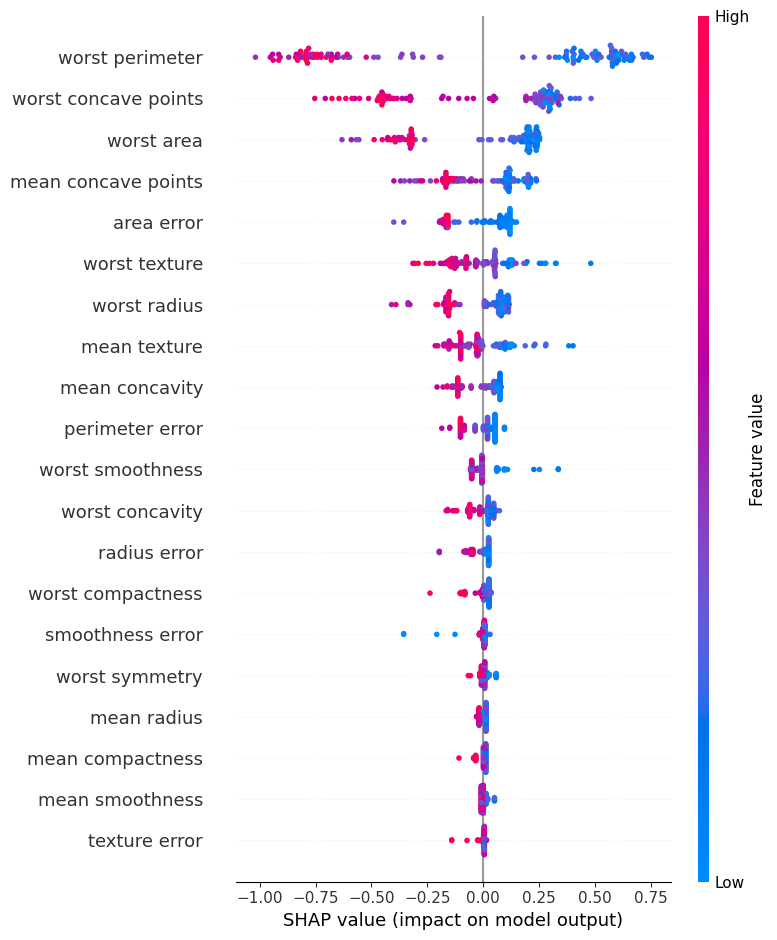


========== LightGBM — SHAP Summary ==========


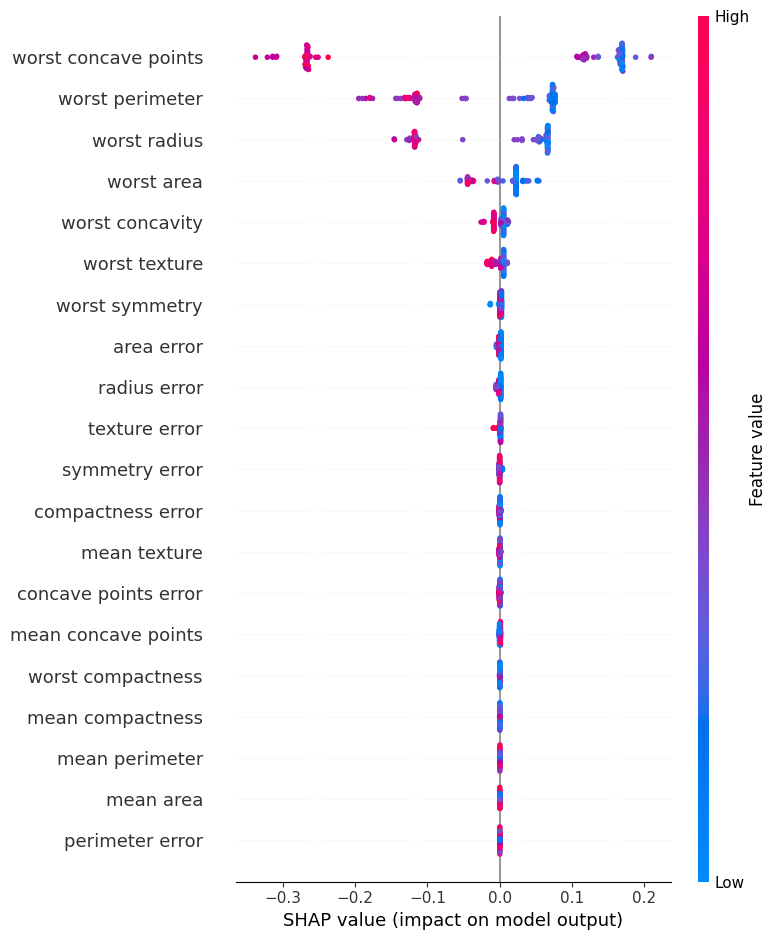


========== CatBoost — SHAP Summary ==========


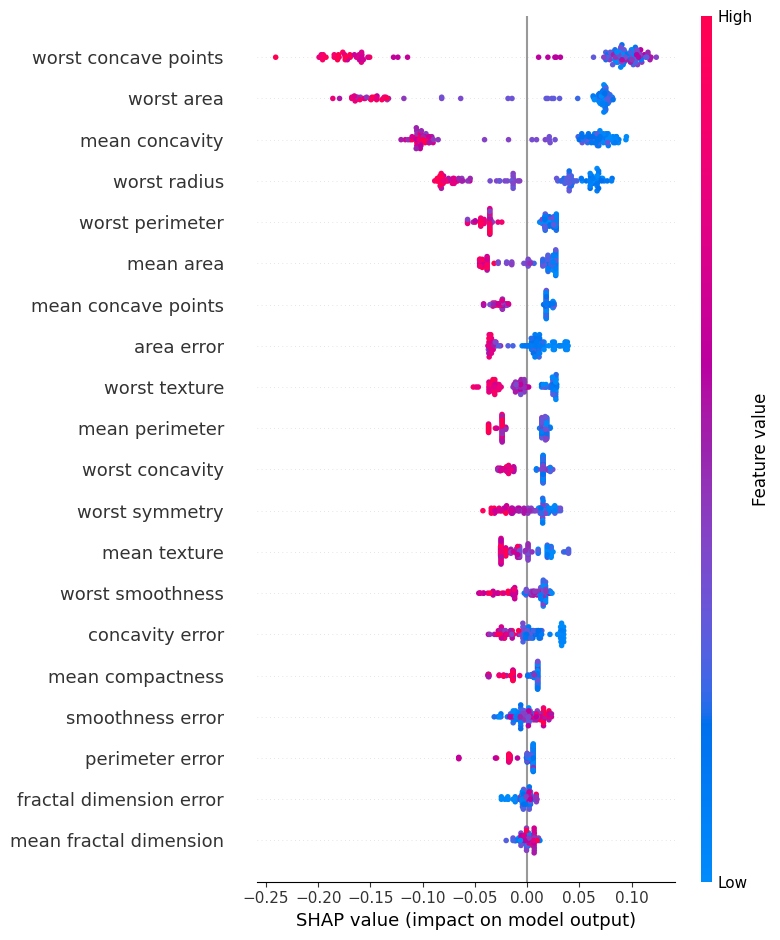


Top-15 features por |SHAP| — XGBoost
             feature  mean|SHAP|
     worst perimeter    0.596834
worst concave points    0.326190
          worst area    0.253114
 mean concave points    0.149572
          area error    0.120205
       worst texture    0.118547
        worst radius    0.113249
        mean texture    0.090216
      mean concavity    0.073088
     perimeter error    0.052411
    worst smoothness    0.042038
     worst concavity    0.040882
        radius error    0.032970
   worst compactness    0.025607
    smoothness error    0.014556

Top-15 features por |SHAP| — LightGBM
             feature  mean|SHAP|
worst concave points    0.199201
     worst perimeter    0.089298
        worst radius    0.081227
          worst area    0.028425
     worst concavity    0.007018
       worst texture    0.006976
      worst symmetry    0.001793
          area error    0.001552
        radius error    0.001501
       texture error    0.001108
      symmetry error    0.000647

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# --- helpers --------------------------------------------------------------

def to_xgb_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """Converte colunas categóricas para códigos inteiros (apenas para XGBoost)."""
    out = df.copy()
    for c in out.select_dtypes(include=['category']).columns:
        out[c] = out[c].cat.codes.astype('int32')
    return out

def pick_xgb_model_and_data(X_bg_raw: pd.DataFrame, X_te_raw: pd.DataFrame):
    """
    Retorna (modelo_xgb, X_bg_compat, X_te_compat) tratando diferenças entre
    Booster (API nativa) e XGBClassifier (sklearn), e categorias do pandas.
    """
    # Se você treinou com xgb.train → 'booster' deve existir
    if 'booster' in globals():
        X_bg_compat = to_xgb_numeric(X_bg_raw)
        X_te_compat = to_xgb_numeric(X_te_raw)
        return booster, X_bg_compat, X_te_compat
    # Se você treinou com XGBClassifier → 'xgb' deve existir
    elif 'xgb' in globals():
        X_bg_compat = to_xgb_numeric(X_bg_raw)
        X_te_compat = to_xgb_numeric(X_te_raw)
        return xgb, X_bg_compat, X_te_compat
    else:
        return None, None, None

# --- background sample (para rapidez/estabilidade) ------------------------

bg_size = min(200, len(X_tr))
X_bg = X_tr.sample(bg_size, random_state=42)

# --- monta dicionário de modelos e dados a explicar -----------------------

models = {}

# XGBoost (Booster ou Classifier), com dados tratados p/ categorias
mdl_xgb, X_bg_xgb, X_test_xgb = pick_xgb_model_and_data(X_bg, X_test)
if mdl_xgb is not None:
    models['XGBoost'] = {
        'model': mdl_xgb,
        'X_bg': X_bg_xgb,
        'X_te': X_test_xgb
    }

# LightGBM (aceita DataFrame com categorias nativamente)
models['LightGBM'] = {
    'model': lgbm,
    'X_bg': X_bg,
    'X_te': X_test
}

# CatBoost (aceita DataFrame com categorias; você também pode usar Pool se preferir)
models['CatBoost'] = {
    'model': cbc,
    'X_bg': X_bg,
    'X_te': X_test
}

# --- gera explicações ------------------------------------------------------

explanations = {}
for name, pack in models.items():
    model = pack['model']
    X_bg_ = pack['X_bg']
    X_te_ = pack['X_te']

    # Para maior compatibilidade entre versões, use shap.Explainer com background
    explainer = shap.Explainer(model, X_bg_)
    exp = explainer(X_te_)  # retorna objeto Explanation
    explanations[name] = exp

# --- plots (um summary plot por modelo) ------------------------------------

for name, exp in explanations.items():
    print(f"\n{('='*10)} {name} — SHAP Summary {('='*10)}")
    # summary plot baseado no valor |SHAP|
    shap.summary_plot(exp.values, models[name]['X_te'], feature_names=models[name]['X_te'].columns, show=True, max_display=20)
    plt.show()

# --- (opcional) top-k features por média de |SHAP| -------------------------

top_k = 15
for name, exp in explanations.items():
    mean_abs = np.abs(exp.values).mean(axis=0)
    order = np.argsort(-mean_abs)[:top_k]
    top_features = pd.DataFrame({
        'feature': models[name]['X_te'].columns[order],
        'mean|SHAP|': mean_abs[order]
    })
    print(f"\nTop-{top_k} features por |SHAP| — {name}")
    print(top_features.to_string(index=False))


### Interpretando os Gráficos SHAP

#### 1. Summary Plot (Importância Global)
- As features estão ordenadas por importância (de cima para baixo)
- A cor representa o valor da feature (vermelho = alto, azul = baixo)
- A largura mostra a distribuição dos impactos SHAP
- **Interpretação**: Features no topo têm maior impacto nas predições

#### 2. Dependence Plot
- Mostra como a feature mais importante afeta as predições
- O eixo X é o valor da feature
- O eixo Y é o impacto SHAP (contribuição para a predição)
- A cor mostra interações com outras features
- **Interpretação**: A inclinação indica se a relação é positiva ou negativa

#### 3. Force Plot
- Explica uma única predição
- Vermelho empurra a predição para cima, azul para baixo
- A largura das barras é proporcional ao impacto
- **Interpretação**: Mostra exatamente como cada feature contribuiu para esta predição específica

#### 4. Interaction Plot
- Mostra como as features interagem entre si
- Cores mais intensas indicam interações mais fortes
- **Interpretação**: Útil para entender efeitos não-aditivos no modelo

> 💡 **Dica**: Use SHAP values para:
> - Explicar predições individuais para stakeholders
> - Identificar possíveis vieses no modelo
> - Priorizar features para coleta de dados
> - Validar se o modelo está usando features de forma sensata


## Otimização de Hiperparâmetros na Prática

O tuning de modelos GBDT pode ser complexo devido ao grande número de hiperparâmetros. Vamos ver uma abordagem sistemática:

### 1. Parâmetros por Categoria

**Controle de Complexidade**:
- XGBoost: `max_depth`, `min_child_weight`
- LightGBM: `num_leaves`, `min_data_in_leaf`
- CatBoost: `depth`, `l2_leaf_reg`

**Aleatorização/Subamostragem**:
- XGBoost: `subsample`, `colsample_bytree`
- LightGBM: `bagging_fraction`, `feature_fraction`
- CatBoost: `subsample`, `rsm` (random subspace method)

**Taxa de Aprendizado**:
- Todos: `learning_rate` (menor = mais árvores necessárias, mas geralmente melhor generalização)

### 2. Estratégia de Otimização

1. **Baseline com defaults**
2. **Tune Complexidade** → evitar overfitting
3. **Tune Aleatorização** → melhorar generalização
4. **Ajuste fino do learning rate** → balance velocidade/performance

Vamos implementar isso usando `RandomizedSearchCV` com distribuições de busca sensatas:


---

Esse código é uma **rotina completa de otimização do XGBoost** em três etapas, finalizando com plots e tabela para interpretar o impacto do *learning rate*. Aqui está uma explicação em Markdown para você usar antes da célula:

### Otimização do XGBoost

O código realiza uma busca estruturada pelos melhores hiperparâmetros do XGBoost em três etapas:

1. **Otimização da complexidade**
   São ajustados parâmetros que controlam a capacidade do modelo, como profundidade máxima das árvores (`max_depth`), peso mínimo para divisão (`min_child_weight`) e regularização de splits (`gamma`). Isso define o quanto o modelo pode se tornar complexo.

2. **Otimização da aleatorização**
   Testa valores de `subsample` (percentual de amostras usadas em cada árvore), `colsample_bytree` e `colsample_bylevel` (percentual de features usadas). Esses parâmetros introduzem variabilidade e reduzem overfitting.

3. **Grid fino para learning rate**
   Depois de fixar os parâmetros anteriores, avalia-se diferentes taxas de aprendizado (`eta`). Um learning rate baixo exige mais árvores para convergir, mas pode trazer mais estabilidade e performance. O treinamento usa `xgb.train` com *early stopping* para escolher automaticamente o número ideal de árvores.

Ao final, são gerados:

* **Gráficos** mostrando como o learning rate afeta a AUC de validação e o número de árvores necessárias.
* **Tabela** com os resultados para cada valor de learning rate, facilitando a comparação.


👉 Em resumo: o script procura o equilíbrio entre **capacidade do modelo**, **regularização por amostragem** e **taxa de aprendizado**, exibindo de forma clara como cada escolha impacta a performance (AUC) e a eficiência (número de árvores).

Otimizando parâmetros de complexidade...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tempo total: 18.59 segundos

Melhores parâmetros de complexidade:
{'gamma': np.float64(0.03131329245555858), 'max_depth': 4, 'min_child_weight': 2}
Melhor AUC: 0.9883

Otimizando parâmetros de aleatorização...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tempo total: 19.73 segundos

Melhores parâmetros de aleatorização:
{'colsample_bylevel': np.float64(0.6137554084460873), 'colsample_bytree': np.float64(0.9637281608315128), 'subsample': np.float64(0.7035119926400067)}
Melhor AUC: 0.9901


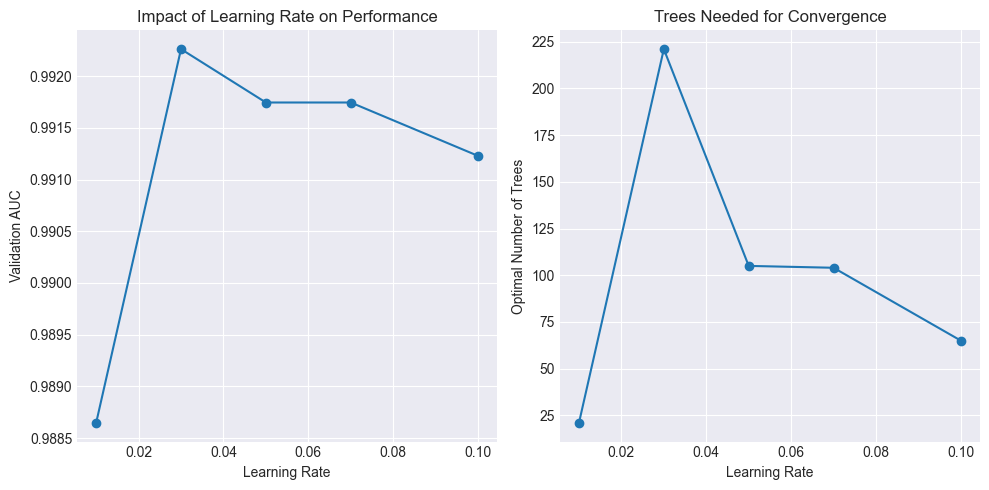


Resultados (grid fino de learning rate):
 learning_rate  n_trees  val_auc
          0.01       21 0.988648
          0.03      221 0.992260
          0.05      105 0.991744
          0.07      104 0.991744
          0.10       65 0.991228


In [18]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# -----------------------------
# 1) Otimização da Complexidade
# -----------------------------
param_dist_complexity = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 1)
}

xgb_complexity = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    tree_method='hist',
    random_state=42
)

rs_complexity = RandomizedSearchCV(
    xgb_complexity,
    param_distributions=param_dist_complexity,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=1
)

print("Otimizando parâmetros de complexidade...")
start_time = time.time()
rs_complexity.fit(X_train, y_train)
print(f"\nTempo total: {time.time() - start_time:.2f} segundos")
print("\nMelhores parâmetros de complexidade:")
print(rs_complexity.best_params_)
print(f"Melhor AUC: {rs_complexity.best_score_:.4f}")

# -------------------------------------------
# 2) Otimização da Aleatorização (subsample…)
# -------------------------------------------
param_dist_random = {
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'colsample_bylevel': uniform(0.6, 0.4)
}

best_complexity_params = rs_complexity.best_params_
xgb_random = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    tree_method='hist',
    random_state=42,
    **best_complexity_params
)

rs_random = RandomizedSearchCV(
    xgb_random,
    param_distributions=param_dist_random,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=1
)

print("\nOtimizando parâmetros de aleatorização...")
start_time = time.time()
rs_random.fit(X_train, y_train)
print(f"\nTempo total: {time.time() - start_time:.2f} segundos")
print("\nMelhores parâmetros de aleatorização:")
print(rs_random.best_params_)
print(f"Melhor AUC: {rs_random.best_score_:.4f}")

# ---------------------------------------------------------------
# 3) Grid fino para learning_rate usando xgboost.train (robusto)
#    - Usa early stopping sem depender do .fit() do wrapper
#    - Funciona mesmo se X_tr/X_val tiverem colunas 'category'
# ---------------------------------------------------------------

best_params = {**best_complexity_params, **rs_random.best_params_}

learning_rates = [0.01, 0.03, 0.05, 0.07, 0.1]
results = []

# helper: cria DMatrix aceitando pandas category (fallback p/ codes)
def make_dmatrix(X, y=None):
    cat_cols = list(X.select_dtypes(include=['category']).columns)
    if len(cat_cols) == 0:
        return xgb.DMatrix(X, label=y)
    # tenta com enable_categorical=True
    try:
        return xgb.DMatrix(X, label=y, enable_categorical=True)
    except Exception:
        # fallback: converter categorias para códigos inteiros
        X_conv = X.copy()
        for c in cat_cols:
            X_conv[c] = X_conv[c].cat.codes.astype('int32')
        return xgb.DMatrix(X_conv, label=y)

dtrain = make_dmatrix(X_tr, y_tr)
dval   = make_dmatrix(X_val, y_val)

for lr in learning_rates:
    params_train = {
        "objective": "binary:logistic",
        "eta": lr,  # learning_rate
        "max_depth": best_params.get("max_depth", 6),
        "min_child_weight": best_params.get("min_child_weight", 1),
        "gamma": float(best_params.get("gamma", 0.0)),
        "subsample": best_params.get("subsample", 1.0),
        "colsample_bytree": best_params.get("colsample_bytree", 1.0),
        "colsample_bylevel": best_params.get("colsample_bylevel", 1.0),
        "eval_metric": "auc",
        "tree_method": "hist",
        "seed": 42
    }

    booster = xgb.train(
        params=params_train,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dval, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # best_score é a AUC do conjunto de avaliação usado pelo early stopping (validation-auc)
    val_score = float(booster.best_score)
    n_trees   = int(booster.best_iteration)

    results.append({
        'learning_rate': lr,
        'n_trees': n_trees,
        'val_auc': val_score
    })

# -------------------------
# 4) Plot dos resultados
# -------------------------
results_df = pd.DataFrame(results).sort_values('learning_rate')

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    pass

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df['learning_rate'], results_df['val_auc'], 'o-')
plt.xlabel('Learning Rate')
plt.ylabel('Validation AUC')
plt.title('Impact of Learning Rate on Performance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df['learning_rate'], results_df['n_trees'], 'o-')
plt.xlabel('Learning Rate')
plt.ylabel('Optimal Number of Trees')
plt.title('Trees Needed for Convergence')
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------
# 5) Tabela de resultados
# -------------------------
# Mostra sem depender do Styler/jinja2 (para evitar erros)
print("\nResultados (grid fino de learning rate):")
print(results_df.to_string(index=False))


### Análise do Processo de Otimização

#### 1. Otimização da Complexidade
- `max_depth`: Controla a profundidade máxima das árvores
  - Valores muito altos → risco de overfitting
  - Valores muito baixos → underfitting
- `min_child_weight`: Soma mínima dos pesos das instâncias necessária em uma folha
  - Aumentar → mais conservador, menos overfitting
  - Diminuir → permite capturar mais padrões locais
- `gamma`: Redução mínima na função de perda para fazer uma divisão
  - Maior gamma = mais conservador

#### 2. Otimização da Aleatorização
- `subsample`: Fração de amostras usadas em cada árvore
- `colsample_bytree`: Fração de features usadas em cada árvore
- `colsample_bylevel`: Fração de features em cada nível
- **Objetivo**: Reduzir variância e melhorar generalização

#### 3. Ajuste do Learning Rate
Observe nos gráficos:
- **Learning Rate vs AUC**: 
  - Taxas muito baixas podem não convergir no número máximo de iterações
  - Taxas muito altas podem "pular" o ótimo
- **Learning Rate vs Número de Árvores**:
  - Relação aproximadamente inversa
  - Learning rates menores precisam de mais árvores para convergir

### Recomendações Práticas

1. **Comece Simples**:
   - Use os defaults primeiro
   - Estabeleça uma baseline sólida
   - Monitore overfitting desde o início

2. **Otimize em Fases**:
   - Complexidade → Aleatorização → Learning Rate
   - Use validação cruzada para maior robustez
   - Mantenha alguns dados para teste final

3. **Balance Custo-Benefício**:
   - Learning rates menores geralmente dão resultados melhores
   - Mas o custo computacional aumenta
   - Encontre um ponto de equilíbrio para seu caso

4. **Monitore Recursos**:
   - Tempo de treinamento
   - Uso de memória
   - Tamanho do modelo final


## Conclusão e Guia Prático

### O que Aprendemos?

1. **Fundamentos do Gradient Boosting**
   - Modelos aditivos que aprendem sequencialmente
   - Cada nova árvore corrige erros das anteriores
   - Regularização via learning rate e complexidade das árvores

2. **Comparação das Bibliotecas**
   - **XGBoost**: Pioneiro, robusto, bem documentado
   - **LightGBM**: Mais rápido, especialmente em datasets grandes
   - **CatBoost**: Excelente com features categóricas

3. **Práticas Essenciais**
   - Sempre use early stopping
   - Monitore overfitting com validação
   - Interprete resultados com SHAP
   - Otimize hiperparâmetros sistematicamente

### Checklist para Projetos Reais 📋

1. **Preparação**
   - [ ] Análise exploratória dos dados
   - [ ] Tratamento de missing values
   - [ ] Encoding de variáveis categóricas
   - [ ] Split treino/validação/teste

2. **Modelagem Inicial**
   - [ ] Baseline com defaults
   - [ ] Early stopping configurado
   - [ ] Métricas de avaliação definidas
   - [ ] Cross-validation quando possível

3. **Otimização**
   - [ ] Tune complexidade primeiro
   - [ ] Ajuste aleatorização
   - [ ] Refine learning rate
   - [ ] Valide em dados de teste

4. **Produção**
   - [ ] Monitore performance
   - [ ] Planeje retreinamento
   - [ ] Documente decisões
   - [ ] Prepare interpretabilidade

### Quando Usar Cada Biblioteca? 🤔

```python
def escolher_biblioteca(dataset):
    if dataset.tem_muitas_categoricas:
        return "CatBoost"
    elif dataset.eh_muito_grande:
        return "LightGBM"
    else:
        return "XGBoost"  # Opção segura e bem documentada
```

### Recursos para Aprofundamento 📚

1. **Documentação Oficial**
   - [XGBoost Docs](https://xgboost.readthedocs.io/)
   - [LightGBM Docs](https://lightgbm.readthedocs.io/)
   - [CatBoost Docs](https://catboost.ai/)

2. **Artigos Técnicos**
   - [XGBoost Paper](https://arxiv.org/abs/1603.02754)
   - [LightGBM Paper](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree)
   - [CatBoost Paper](https://arxiv.org/abs/1706.09516)

3. **Competições e Cases**
   - [Kaggle Notebooks](https://www.kaggle.com/notebooks)
   - [GitHub Examples](https://github.com/topics/gradient-boosting)

### Próximos Passos 🚀

1. **Experimente em Seus Dados**
   - Aplique os conceitos em seus próprios projetos
   - Compare performance com seus modelos atuais
   - Documente aprendizados

2. **Aprofunde-se**
   - Estude os papers originais
   - Explore parâmetros avançados
   - Participe de competições

3. **Melhores Práticas**
   - Automatize pipelines
   - Implemente CI/CD
   - Monitore modelos em produção



## 7) Comparativo rápido
Consolidando resultados das execuções acima.

In [19]:
# =============================
# RESUMO FINAL DOS RESULTADOS
# =============================

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- 1) Tabela do grid fino do XGBoost ---
# (assumindo que o loop de tuning salvou em xgb_tuning_results)
xgb_tuning_df = pd.DataFrame(xgb_tuning_results).rename(columns={
    "val_auc": "AUC",
    "n_trees": "N_Trees",
    "learning_rate": "Learning Rate"
})

print("\n=== Tuning do XGBoost (Learning Rate) ===")
print(xgb_tuning_df.to_string(index=False))

# --- 2) Resumo comparativo final de todos os modelos ---

def safe_eval(name, pred_func, proba_func=None):
    try:
        pred = pred_func()
        proba = proba_func() if proba_func is not None else np.ones(len(y_test)) * 0.5
        return {
            "model": name,
            "acc": accuracy_score(y_test, pred),
            "f1": f1_score(y_test, pred),
            "auc": roc_auc_score(y_test, proba)
        }
    except Exception:
        return {"model": name, "acc": np.nan, "f1": np.nan, "auc": np.nan}

final_results = []

# Baselines (results_baseline foi definido antes: LogisticRegression + RandomForest)
final_results.extend(results_baseline)

# XGBoost (usando booster treinado)
final_results.append(safe_eval(
    "XGBoost",
    lambda: (booster.predict(dtest, iteration_range=(0, booster.best_iteration+1)) >= 0.5).astype(int),
    lambda: booster.predict(dtest, iteration_range=(0, booster.best_iteration+1))
))

# LightGBM
final_results.append(safe_eval(
    "LightGBM",
    lambda: lgbm.predict(X_test_lgb),
    lambda: lgbm.predict_proba(X_test_lgb)[:,1]
))

# CatBoost
final_results.append(safe_eval(
    "CatBoost",
    lambda: cbc.predict(test_pool),
    lambda: cbc.predict_proba(test_pool)[:,1]
))

final_df = pd.DataFrame(final_results)

print("\n=== Resumo comparativo final dos modelos ===")
print(final_df.to_string(index=False))

# --- 3) Salvar CSVs ---
xgb_tuning_df.to_csv("xgb_tuning_summary.csv", index=False)
final_df.to_csv("models_comparative_summary.csv", index=False)

print("\nArquivos salvos: 'xgb_tuning_summary.csv' e 'models_comparative_summary.csv'")



=== Tuning do XGBoost (Learning Rate) ===
 Learning Rate  N_Trees      AUC  Tempo (s)
          0.01      111 0.986584   0.188153
          0.03       59 0.987616   0.120840
          0.05       15 0.988132   0.073373
          0.07      137 0.989680   0.166721
          0.10       15 0.987616   0.073716

=== Resumo comparativo final dos modelos ===
             model      acc       f1      auc
LogisticRegression 0.964912 0.972222 0.995370
      RandomForest 0.947368 0.958333 0.992725
           XGBoost 0.947368 0.958333 0.991071
          LightGBM 0.903509 0.929032 0.986938
          CatBoost 0.956140 0.965986 0.988757

Arquivos salvos: 'xgb_tuning_summary.csv' e 'models_comparative_summary.csv'


## 8) Desbalanceamento de classes

- **XGBoost**: `scale_pos_weight = (n_neg / n_pos)`
- **LightGBM**: `is_unbalance=True` **ou** `scale_pos_weight`
- **CatBoost**: `class_weights=[w0, w1]` (ou `auto_class_weights`)

Exemplo (não-executado por padrão):


In [20]:
# Exemplo de configuração para desbalanceamento (use quando necessário)
pos = y_train.sum(); neg = len(y_train) - pos
scale_pos = neg / max(pos, 1)

# XGBoost
xgb_imb = XGBClassifier(scale_pos_weight=scale_pos, tree_method='hist')

# LightGBM
lgbm_imb = lgb.LGBMClassifier(is_unbalance=True)

# CatBoost
cbc_imb = CatBoostClassifier(class_weights=[1.0, float(scale_pos)])

## 9) Monotonic constraints (XGBoost/LightGBM)
Quando você **sabe** que a relação entre uma feature e o alvo deve ser monotônica (ex.: renda ↑ → risco ↓), imponha **restrições monotônicas**:
- XGBoost: `monotone_constraints` como string JSON, ex.: `"(1, -1, 0, ...)"` 
- LightGBM: `monotone_constraints=[1, -1, 0, ...]`

Exemplo ilustrativo:


In [21]:
# Suponha que queremos forçar monotonicidade positiva na primeira coluna e negativa na segunda
monos_xgb = "(1,-1," + ",".join(["0"] * (X_tr.shape[1]-2)) + ")"
xgb_mono = XGBClassifier(tree_method='hist', monotone_constraints=monos_xgb)

monos_lgb = [1, -1] + [0]*(X_tr.shape[1]-2)
lgbm_mono = lgb.LGBMClassifier(monotone_constraints=monos_lgb)

## 10) Interpretação com SHAP
Podemos usar **SHAP** para explicar predições e importância global/local.
Abaixo um exemplo para o modelo XGBoost (cuidado com tempo de execução):

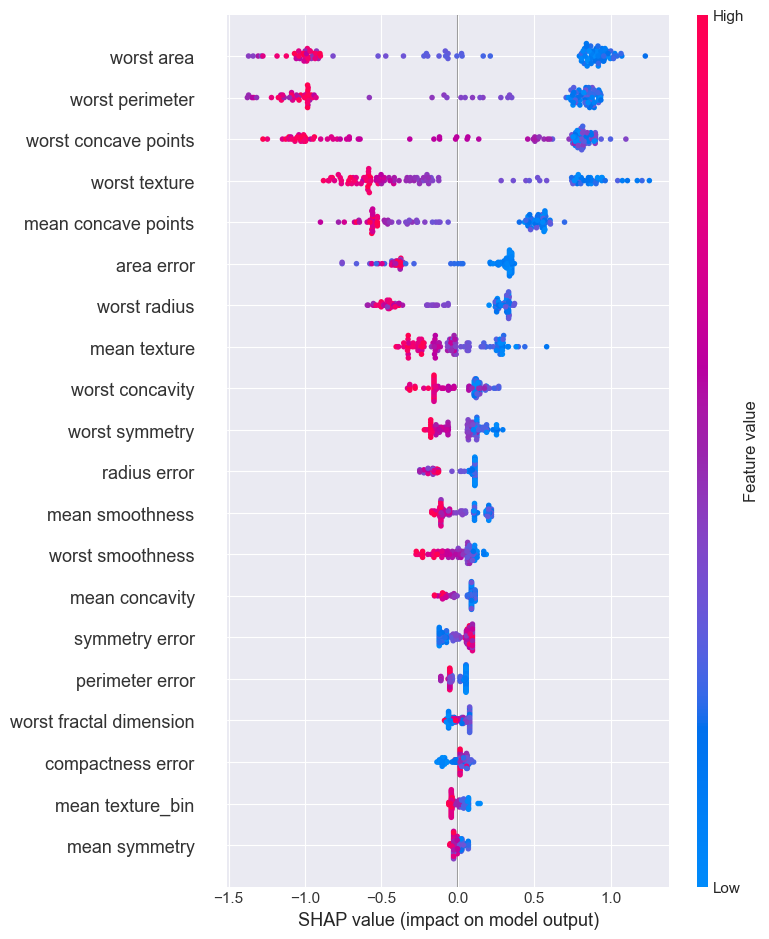

In [22]:
X_test_xgb = to_xgb_numeric(X_test)  # garante compatibilidade
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_xgb)
shap.summary_plot(shap_values, X_test_xgb, show=False)
plt.tight_layout()
plt.show()


## 11) Boas práticas de *tuning*

### XGBoost (guia rápido)
- Comece com `tree_method='hist'` (ou `gpu_hist` se tiver GPU)
- Ajuste **complexidade**: `max_depth` (3–8), `min_child_weight` (1–10)
- Ajuste **amostragem**: `subsample` e `colsample_bytree` (0.6–1.0)
- Ajuste **regularização**: `reg_lambda` (1–10), `reg_alpha` (0–2)
- `n_estimators` alto + `learning_rate` baixo + *early stopping*

### LightGBM
- **`num_leaves`** determina complexidade efetiva (regra prática: `num_leaves ≈ 2^(max_depth)`) 
- Use `min_data_in_leaf` e `feature_fraction`/`bagging_fraction` para regularizar
- `max_bin` pode ajudar em dados com muita variação

### CatBoost
- Geralmente bons *defaults*
- Ajuste `depth` (4–10), `learning_rate`, `l2_leaf_reg`
- `border_count` (binning) pode impactar desempenho
- Para muitas categóricas de alta cardinalidade, **CatBoost** costuma exigir menos *feature engineering*

### Estratégia geral
1. Fixe *pipeline* (preprocessamento, splits, métricas)
2. Faça varredura grossa (grid/aleatório) em poucos hiperparâmetros
3. Fixe *early stopping*
4. *Refine* localmente em torno dos melhores candidatos
5. Valide com *cross-validation* quando possível


## 12) Checklist de produção
- *Early stopping* e *learning curves*
- Checar *drift* de dados e re‑treino programado
- Versão de dados/modelo, *feature store* (se aplicável)
- Monitorar métricas em tempo real (AUC, KS, PSI)
- Interpretabilidade (SHAP) e **monotonic constraints** quando houver requisitos regulatórios
- Cuidado com **leakage** (particularmente em CatBoost ao construir estatísticas de alvo fora do *fit*)
- Exportação para produção (`Booster.save_model`, `cbm`, `onnx` em alguns cenários)


## 13) Apêndice: Exemplo de *RandomizedSearchCV*
Trecho ilustrativo para XGBoost; adapte para LightGBM/CatBoost conforme necessário.

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_lambda': uniform(0, 10),
    'reg_alpha': uniform(0, 2)
}

xgb_base = XGBClassifier(n_estimators=1000, learning_rate=0.05, tree_method='hist', random_state=42)
rs = RandomizedSearchCV(xgb_base, param_dist, n_iter=20, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1, random_state=42)
# rs.fit(X_train, y_train)  # Descomente para rodar
# rs.best_params_, rs.best_score_

---
### Referências úteis
- XGBoost docs: https://xgboost.readthedocs.io/
- LightGBM docs: https://lightgbm.readthedocs.io/
- CatBoost docs: https://catboost.ai/
- SHAP docs: https://shap.readthedocs.io/